<a href="https://colab.research.google.com/github/anujdutt9/TFUG_Projects/blob/main/EuroSat_Land_Cover_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Tue Dec 22 19:51:19 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    25W / 300W |      0MiB / 16130MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import Dependencies
import os
import numpy as np
import datetime
import time
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import MobileNetV3Small
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
tf.__version__

'2.4.0'

In [4]:
# Load Dataset
(train_ds, val_ds, test_ds), info = tfds.load('eurosat/rgb', split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], as_supervised=True, with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/eurosat/rgb/2.0.0.incompleteRUWPBY/eurosat-train.tfrecord


Dataset eurosat downloaded and prepared to /root/tensorflow_datasets/eurosat/rgb/2.0.0. Subsequent calls will reuse this data.


In [5]:
# Dataset Info
info

tfds.core.DatasetInfo(
    name='eurosat',
    version=2.0.0,
    description='EuroSAT dataset is based on Sentinel-2 satellite images covering 13 spectral
bands and consisting of 10 classes with 27000 labeled and
geo-referenced samples.

Two datasets are offered:
- rgb: Contains only the optical R, G, B frequency bands encoded as JPEG image.
- all: Contains all 13 bands in the original value range (float32).

URL: https://github.com/phelber/eurosat',
    homepage='https://github.com/phelber/eurosat',
    features=FeaturesDict({
        'filename': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    }),
    total_num_examples=27000,
    splits={
        'train': 27000,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{helber2017eurosat,
        title={EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification},
      

In [6]:
# Dataset features
info.features

FeaturesDict({
    'filename': Text(shape=(), dtype=tf.string),
    'image': Image(shape=(64, 64, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
})

In [7]:
print("Number of classes: ", info.features["label"].num_classes)
print("Labels: ", info.features["label"].names)
print("Label to Int Mapping: ", info.features["label"].str2int('Industrial'))

Number of classes:  10
Labels:  ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Label to Int Mapping:  4


,image,label
0,,9 (SeaLake)
1,,1 (Forest)
2,,3 (Highway)
3,,7 (Residential)

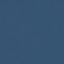
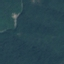
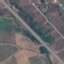
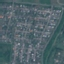

In [8]:
# Show sample images from dataset as DataFrame
tfds.as_dataframe(train_ds.take(4), info)

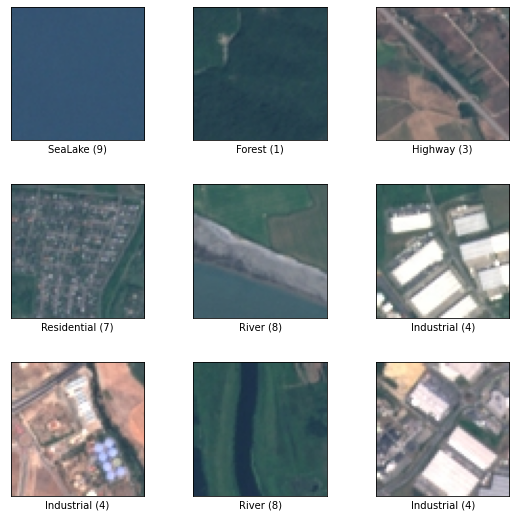

In [9]:
# Show sample images from Dataset
fig = tfds.show_examples(train_ds, info)

In [10]:
# Get list of labels
classes = info.features["label"].names
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [11]:
# Parameters
NUM_EPOCHS = 50
BATCH_SIZE = 64
BUFFER_SIZE = 1000
IMAGE_SHAPE = [224, 224]
NUM_CLASSES = info.features["label"].num_classes

In [12]:
# Data Augmentation
@tf.function
def prepare_training_data(image, label):
  input_image = preprocess_image(image)
  input_image = tf.image.resize(image, IMAGE_SHAPE)
  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.random_flip_left_right(input_image)
    input_image = tf.image.random_flip_up_down(input_image)
    input_image = tf.image.random_brightness(input_image, max_delta=0.3)
    input_image = tf.image.random_saturation(input_image, lower=0.75, upper=1.5)
    input_image = tf.image.random_contrast(input_image, lower=0.75, upper=1.5)
  # input_image = preprocess_input(input_image)

  return input_image, label

def prepare_validation_data(image, label):
  input_image = preprocess_image(image)
  input_image = tf.image.resize(image, IMAGE_SHAPE)
  # input_image = preprocess_input(input_image)
  
  return input_image, label

# Function to perform image normalization
# dividing by 127.5 i.e 255/2 provides quantized models with values
# in range from [-1, 1] i.e. values centred around 127.5
def preprocess_image(image):
  image = tf.cast(image, tf.float32)
  image = image / 127.5
  image -= 1.
  return image

In [13]:
# Pre-process train/val/test data
train_data = train_ds.map(lambda x, y: prepare_training_data(x, y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_data = val_ds.map(lambda x, y: prepare_validation_data(x, y))
test_data = test_ds.map(lambda x, y: (tf.image.resize(x, IMAGE_SHAPE), y))

In [14]:
# Prefetch batch of train/val/test data
train_dataset = train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = val_data.batch(BATCH_SIZE)
test_dataset = test_data.batch(BATCH_SIZE)

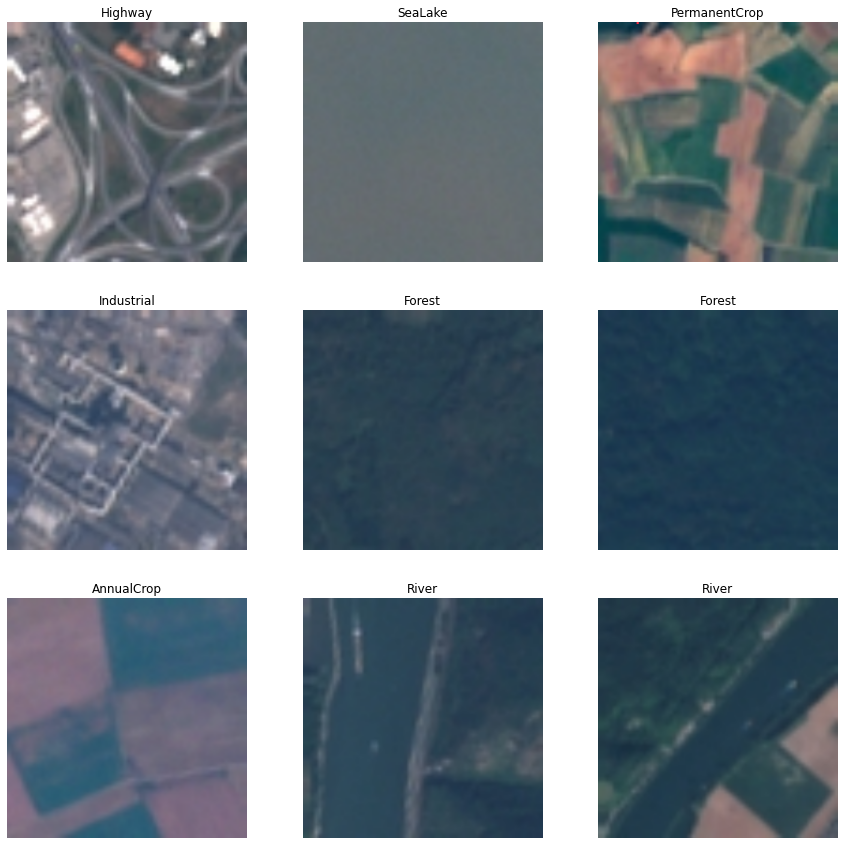

In [15]:
# Visualize images after augmentation
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  for (image, label) in tfds.as_numpy(train_dataset.take(1)):
    plt.imshow(image[0].astype('uint8'))
    plt.title(classes[label[0]])
    plt.axis("off")
plt.show()

In [16]:
# Function to create model
def create_model():
  # load pre-trained model
  model = MobileNetV3Small(input_shape=IMAGE_SHAPE+[3], weights='imagenet', include_top=False)

  # Freeze Layers
  for layer in model.layers:
    layer.trainable = False

  # add trainable layers
  x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(512, activation='relu')(x)
  predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

  # final model
  model = tf.keras.models.Model(inputs=model.input, outputs=predicition)
  
  # Compile the model
  model.compile(
      loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
      optimizer=tf.keras.optimizers.SGD(),
      metrics=['accuracy']
  )

  return model

In [17]:
# Create Model Instance
model = create_model()

6701056/6698480 [==============================] - 0s 0us/step


In [18]:
# Model Summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
______________________________________________________________________________________________

In [19]:
# Number of Train/Validation steps
STEPS_PER_EPOCH = int(info.splits["train"].num_examples * 0.8)//BATCH_SIZE
VALIDATION_STEPS = int(info.splits["train"].num_examples * 0.1)//BATCH_SIZE

In [20]:
# Learning Rate Scheduler
def lr_schedule(epoch):
  """
  Returns a custom learning rate that decreases as epochs progress.
  """
  learning_rate = 0.2
  if epoch > 5:
    learning_rate = 0.02
  if epoch > 10:
    learning_rate = 0.01
  if epoch > 15:
    learning_rate = 0.005

  tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
  return learning_rate

# Learning Rate Scheduler Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Save model checkpoint
checkpoint_path = "eurosat/model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# Train Model
history = model.fit(
    train_dataset,
    epochs = NUM_EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=validation_dataset,
    validation_steps=VALIDATION_STEPS,
    callbacks=[early_stopping, lr_callback, cp_callback]
)

Epoch 1/50
337/337 [==============================] - 34s 78ms/step - loss: 0.8057 - accuracy: 0.7447 - val_loss: 0.2858 - val_accuracy: 0.9048

Epoch 00001: val_loss improved from inf to 0.28580, saving model to eurosat/model.ckpt
Epoch 2/50
337/337 [==============================] - 10s 30ms/step - loss: 0.2764 - accuracy: 0.9027 - val_loss: 0.1895 - val_accuracy: 0.9386

Epoch 00002: val_loss improved from 0.28580 to 0.18948, saving model to eurosat/model.ckpt
Epoch 3/50
337/337 [==============================] - 10s 30ms/step - loss: 0.2209 - accuracy: 0.9235 - val_loss: 0.1724 - val_accuracy: 0.9386

Epoch 00003: val_loss improved from 0.18948 to 0.17241, saving model to eurosat/model.ckpt
Epoch 4/50
337/337 [==============================] - 10s 30ms/step - loss: 0.1920 - accuracy: 0.9324 - val_loss: 0.2508 - val_accuracy: 0.9152

Epoch 00004: val_loss did not improve from 0.17241
Epoch 5/50
337/337 [==============================] - 10s 29ms/step - loss: 0.1802 - accuracy: 0.938

In [21]:
model.save('eurosat_model.h5')

In [22]:
# Save trained model
import tempfile

tmpdir = tempfile.mkdtemp()
mobilenet_save_path = os.path.join(tmpdir, "mobilenet_v3_small/")
tf.saved_model.save(model, mobilenet_save_path)

INFO:tensorflow:Assets written to: /tmp/tmpk8y41ju6/mobilenet_v3_small/assets


INFO:tensorflow:Assets written to: /tmp/tmpk8y41ju6/mobilenet_v3_small/assets


In [23]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

prediction_classes = np.argmax(predictions, axis=1)
acc = accuracy_score(prediction_classes, label_batch)
print('Test batch accuracy: ', acc)

Test batch accuracy:  0.96875


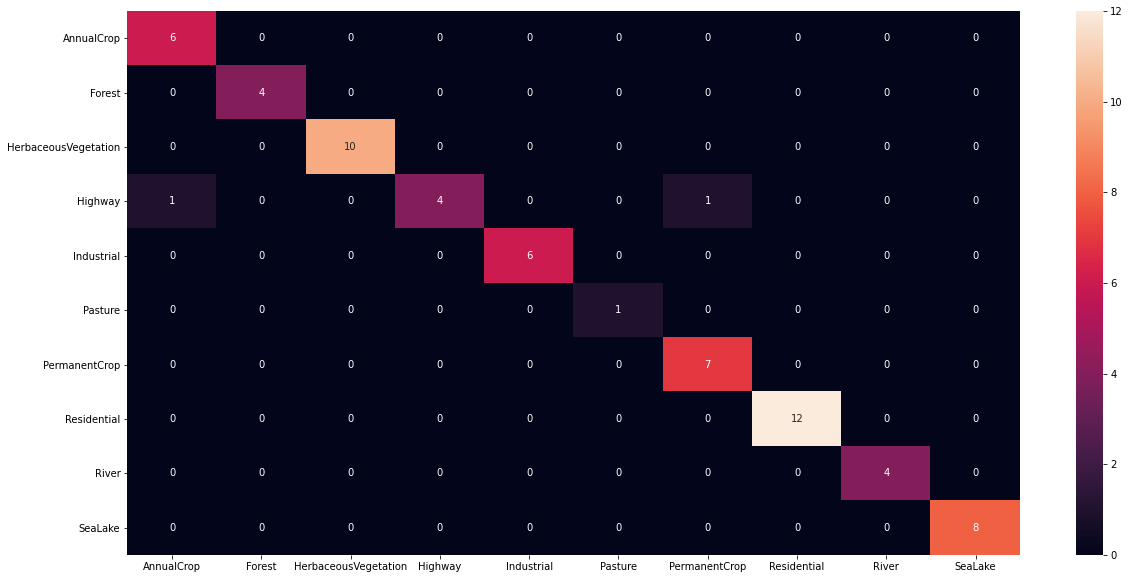

In [24]:
# Confusion Matrix
import seaborn as sn

plt.figure(figsize=(20,10))
conf_matrix = confusion_matrix(label_batch, prediction_classes)
sn.heatmap(conf_matrix, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

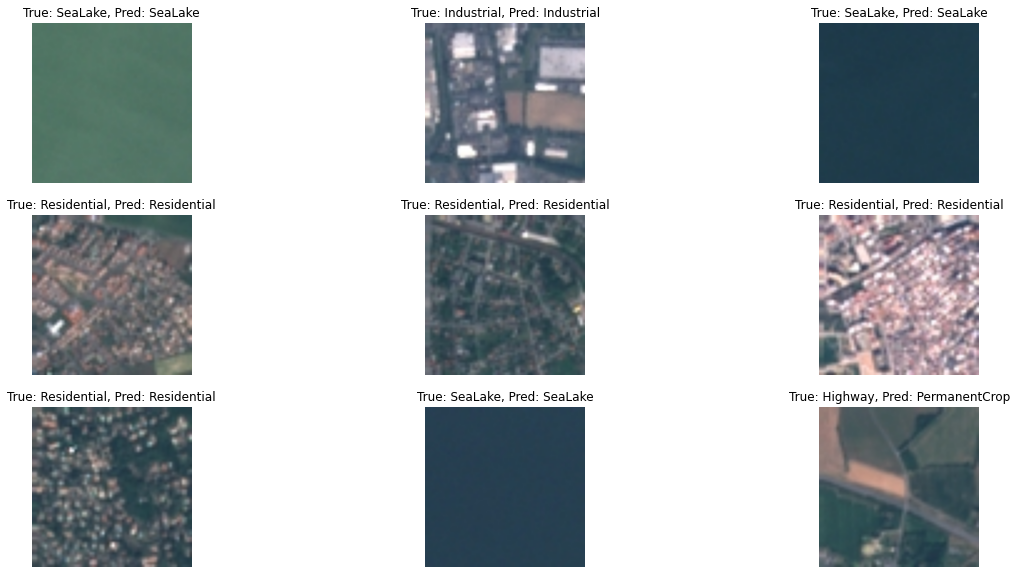

In [25]:
# Plot True vs Predicted labels
plt.figure(figsize=(20, 10))
for i in range(9):
  msg = "True: " + str(classes[label_batch[i]]) + ", " + "Pred: " + str(classes[np.argmax(predictions[i])])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(msg)
  plt.axis("off")

## Convert Saved Model to TFLite Model

In [26]:
# Convert the model to TFLite with FP-32 weights
converter = tf.lite.TFLiteConverter.from_saved_model(mobilenet_save_path)
tflite_model = converter.convert()

# Save the model.
with open('eurosat_model_fp32.tflite', 'wb') as f:
  f.write(tflite_model)

In [27]:
# Convert the model to TFLite using Dynamic range quantization
# Weights saved as Int8 in model, converted from Int8 -> FP32 while performing inference
converter = tf.lite.TFLiteConverter.from_saved_model(mobilenet_save_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the model.
with open('eurosat_model_dynamic_range.tflite', 'wb') as f:
  f.write(tflite_model)

In [28]:
# Convert the model to TFLite with FP16
# FP-16/32 are supported on GPU for a number of Ops listed here: 
# https://www.tensorflow.org/lite/performance/gpu_advanced#supported_ops
converter = tf.lite.TFLiteConverter.from_saved_model(mobilenet_save_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert()

# Save the model.
with open('eurosat_model_fp16.tflite', 'wb') as f:
  f.write(tflite_model)

## Compare TFLite Models

In [29]:
# Helper Functions
def get_file_size(file_path):
    size = os.path.getsize(file_path)
    return size

def convert_bytes(size, unit=None):
    if unit == "KB":
        return str(str(round(size / 1024, 3)) + ' KB')
    elif unit == "MB":
        return str(str(round(size / (1024 * 1024), 3)) + ' MB')
    else:
        return str(str(size) + ' bytes')

In [30]:
# Model Size Comparison
print('original_model_size: ', convert_bytes(get_file_size('eurosat_model.h5'), "MB"))
print('tflite_fp32_model_size: ', convert_bytes(get_file_size('eurosat_model_fp32.tflite'), "MB"))
print('tflite_fp16_model_size: ', convert_bytes(get_file_size('eurosat_model_fp16.tflite'), "MB"))
print('tflite_int8_model_size: ', convert_bytes(get_file_size('eurosat_model_dynamic_range.tflite'), "MB"))

original_model_size:  8.515 MB
tflite_fp32_model_size:  7.827 MB
tflite_fp16_model_size:  3.947 MB
tflite_int8_model_size:  2.214 MB


## Test TFLite Models

In [31]:
def tflite_inference(tflite_model_path=None):
  # Check TFLite Input Tensor Shape
  interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  print("Input Shape:", input_details[0]['shape'])
  print("Input Type:", input_details[0]['dtype'])
  print("Output Shape:", output_details[0]['shape'])
  print("Output Type:", output_details[0]['dtype'])
  print('\n')

  # Change Input Tensor Shape to perform inference in batches
  interpreter.resize_tensor_input(input_details[0]['index'], (BATCH_SIZE, 224, 224, 3))
  interpreter.resize_tensor_input(output_details[0]['index'], (BATCH_SIZE, 10))
  interpreter.allocate_tensors()
  input_details = interpreter.get_input_details()
  output_details = interpreter.get_output_details()
  print("Reshaped Input Shape:", input_details[0]['shape'])
  print("Reshaped Input Type:", input_details[0]['dtype'])
  print("Reshaped Output Shape:", output_details[0]['shape'])
  print("Reshaped Output Type:", output_details[0]['dtype'])
  print('\n')

  for i, (image, label) in enumerate(tfds.as_numpy(train_dataset.take(5))):
    start = time.time()
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()
    tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
    end = time.time()
    prediction_classes = np.argmax(tflite_model_predictions, axis=1)
    acc = accuracy_score(prediction_classes, label)
    print('Batch: ', i+1,
          '\tAccuracy: {:.2f}'.format(acc), 
          '\tInference Time: {:.2f} seconds'.format((end - start)))
  
  return acc

In [32]:
# TFLite Model Paths
tflite_fp32_model_path =  'eurosat_model_fp32.tflite'
tflite_fp16_model_path =  'eurosat_model_fp16.tflite'
tflite_int8_model_path = 'eurosat_model_dynamic_range.tflite'

In [33]:
# FP-32 Model
tflite_inference(tflite_model_path=tflite_fp32_model_path)

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


Reshaped Input Shape: [ 64 224 224   3]
Reshaped Input Type: <class 'numpy.float32'>
Reshaped Output Shape: [64 10]
Reshaped Output Type: <class 'numpy.float32'>


Batch:  1 	Accuracy: 0.94 	Inference Time: 0.87 seconds
Batch:  2 	Accuracy: 0.97 	Inference Time: 0.77 seconds
Batch:  3 	Accuracy: 0.98 	Inference Time: 0.78 seconds
Batch:  4 	Accuracy: 0.97 	Inference Time: 0.77 seconds
Batch:  5 	Accuracy: 0.98 	Inference Time: 0.76 seconds


0.984375

In [34]:
# FP-16/32 model supports GPU Delegates
tflite_inference(tflite_model_path=tflite_fp16_model_path)

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


Reshaped Input Shape: [ 64 224 224   3]
Reshaped Input Type: <class 'numpy.float32'>
Reshaped Output Shape: [64 10]
Reshaped Output Type: <class 'numpy.float32'>


Batch:  1 	Accuracy: 1.00 	Inference Time: 0.80 seconds
Batch:  2 	Accuracy: 0.98 	Inference Time: 0.76 seconds
Batch:  3 	Accuracy: 0.94 	Inference Time: 0.77 seconds
Batch:  4 	Accuracy: 1.00 	Inference Time: 0.75 seconds
Batch:  5 	Accuracy: 0.98 	Inference Time: 0.74 seconds


0.984375

In [35]:
# Int8 Model
tflite_inference(tflite_model_path=tflite_int8_model_path)

Input Shape: [  1 224 224   3]
Input Type: <class 'numpy.float32'>
Output Shape: [ 1 10]
Output Type: <class 'numpy.float32'>


Reshaped Input Shape: [ 64 224 224   3]
Reshaped Input Type: <class 'numpy.float32'>
Reshaped Output Shape: [64 10]
Reshaped Output Type: <class 'numpy.float32'>


Batch:  1 	Accuracy: 0.84 	Inference Time: 13.97 seconds
Batch:  2 	Accuracy: 0.86 	Inference Time: 13.75 seconds
Batch:  3 	Accuracy: 0.72 	Inference Time: 13.76 seconds
Batch:  4 	Accuracy: 0.78 	Inference Time: 13.91 seconds
Batch:  5 	Accuracy: 0.83 	Inference Time: 13.55 seconds


0.828125

In [36]:
# Download TFLite Model
from google.colab import files
files.download(tflite_fp16_model_path)